In [2]:
import numpy as np
import matplotlib.pyplot as plt

## The Wong Wang Attractor Model

Note two basins of attraction representing either choice. This is shown through the phase space

In [18]:
def ww_params( **kwargs):
    pars = {}
    
    ### gain variables ###
    pars['a'] = 270.   # Gain of the E population
    pars['b'] = 108.   # Threshold of the E population
    pars['d'] = 0.154
    
    ### synaptic parameters ###
    pars['tauS']  = 0.1   # Timescale of the E population [sec]
    pars['gamma'] = 0.641  # Saturation factor for gating variable 

    ### Connection strength ###
    pars['JE'] = 0.2609 # local self-coupling strength [nA]
    pars['JI'] = -0.0497 # local cross-coupling strength [nA]
    
    ### background input####
    pars['Ib1'] = 0.3255 # background current [nA]
    pars['Ib2'] = 0.3255 # background current [nA]
    ### OU background noise ###
    pars['tau0'] = 0.002 # Noise time constant [sec]
    pars['sigma'] = 0.02 # Noise magnitude [nA]
    pars['myseed'] = None

    ### simulation parameters ###
    pars['T']         = 5. # Total duration of simulation [sec]
    pars['dt']        = 0.0005 # Simulation time step [sec]
    pars['dt_smooth'] = 0.02 # Temporal window size for smoothing [sec]
    pars['s1_init'] = 0.0 # Initial value of s1, low hierarchy
    pars['s2_init'] = 0.0 # Initial value of s2, high hierarchy
    
    ### Stimulus Parameters ###
    pars['Jext'] = 5.2e-4 # Stimulus input strength [nA]
    pars['mu0']  = 30 #20.    # Strength of stimulus 1 [dimensionless]
    pars['mu1'] = 20
    pars['mu2'] = 80
    pars['coh'] = 0
    pars['Ntrials'] = 5   # Total number of trials
    pars['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    pars['Tdur'] = 2.     # Duration of stimulus 1 [sec]

    return pars

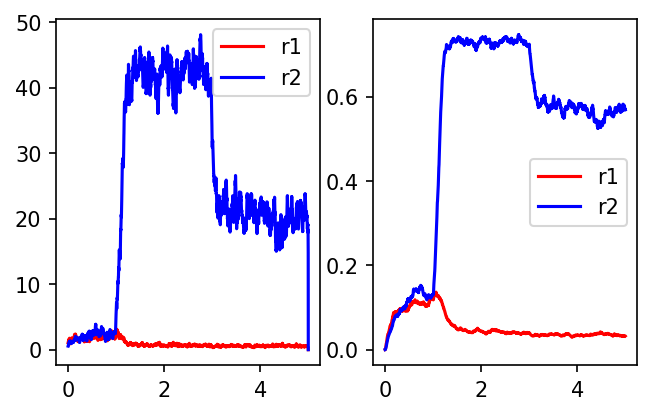

In [84]:
def F(I, a=270, b=108, d=0.154):
    '''
    rate [Hz] as a function of total input current [nA]
    '''
    return (a*I - b)/(1 - np.exp(-d*(a*I - b)))

def wongwang(params):
    '''
    Run simulation, for multiple trials.
    
    Parameters:
    pars : circuit model parameters
    
    Return: dictionary with activity traces
    '''
    globals().update(params)
    NT = int(T/dt)
    timerange = np.linspace(0,T, NT)

    gwn = np.random.randn(NT, 2)

    #Initialize
    r1smooth = []
    r2smooth = []
    
    Ieta1 = np.zeros(NT+1)
    Ieta2 = np.zeros(NT+1)
    S1 = np.zeros(NT)
    S2 = np.zeros(NT)
    r1 = np.zeros(NT)
    r2 = np.zeros(NT)
    
    # Initialize S1, S2
    S1[0],  S2[0] = s1_init, s2_init
    
    for t in range(NT-1): #Loop through time for a trial

        #---- Stimulus------------------------------------------------------
        Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu1) # To population 1
        Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu2) # To population 2
                
        # Total synaptic input
        Isyn1 = JE*S1[t] + JI*S2[t] + Istim1 + Ieta1[t]
        Isyn2 = JI*S1[t] + JE*S2[t] + Istim2 + Ieta2[t]
        
        # Transfer function to get firing rate
        r1[t]  = F(Isyn1, a, b, d)
        r2[t]  = F(Isyn2, a, b, d)
    
        #---- Dynamical equations -------------------------------------------

        # Mean NMDA-mediated synaptic dynamics updating
        S1[t+1] = S1[t] + dt*(-S1[t]/tauS + (1-S1[t])*gamma*r1[t]);
        S2[t+1] = S2[t] + dt*(-S2[t]/tauS + (1-S2[t])*gamma*r2[t]);

        # Ornstein-Uhlenbeck generation of noise in pop1 and 2
        Ieta1[t+1] = Ieta1[t] + (dt/tau0) * (Ib1-Ieta1[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
        Ieta2[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
    
    smooth_wind = int(dt_smooth/dt)
    
    r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
    r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])

    z = {'S1':np.array(S1), 'S2':np.array(S2), # NMDA gating variables
        'r1':np.array(r1), 'r2':np.array(r2), # Firing rates
        'r1smooth':np.array(r1smooth), 'r2smooth':np.array(r2smooth), # smoothed firing rates
        't':timerange}

    return z

data = wongwang(ww_params())

fig, axs = plt.subplots(1,2, figsize=(5,3), dpi=150)

axs[0].plot(data['t'], data['r1smooth'], label='r1', color = 'red')
axs[0].plot(data['t'], data['r2smooth'], label='r2', color = 'blue')
axs[0].legend()

axs[1].plot(data['t'], data['S1'], label='r1', color = 'red')
axs[1].plot(data['t'], data['S2'], label='r2', color = 'blue')
axs[1].legend()

### VIP-SOM interneurons
*following Yang 2015*

The total inhibitory conductance received by each dendrite is Gsom = 40 nS. Assume 1 connection.
VIP -SOM connections have connection weight 30pA/Hz. 

PV-PV is 30 pA/Hz
PV-Pyr is 30 pA/Hz|

In [70]:

# VIP
# if targeted firs at 5Hz if not fires at 0 Hz
ifD2 = False
VIP_0 = 5. # baseline VIP firing [Hz]
r_VIP = ifD2 * VIP_0 + .1 # Hz

# SOM
betaSOM = 90    # Hz/nA
Irh_SOM = 0.040  # nA
I_SOM_0 = 0.150
SOM_0 = 0
I_SOM = I_SOM_0 - 0.03 * r_VIP # 0.03 comes from the total inhibitory connection weight from VIP neurons received by each SOM neuron.
r_SOM = np.max(betaSOM * (I_SOM - Irh_SOM)) # should generally be negative (is a change in firing rate)
dr_SOM = np.max(betaSOM * (I_SOM - Irh_SOM)) - np.max(betaSOM * (I_SOM_0 - Irh_SOM))

# PV
ifGRIK4=False
PV_0 = 2 # baseline PV firing [Hz]
betaPV = 220 # [Hz/nA]
wSOM_PV = 30/1000 #[nA/Hz]
wPV_PV = 30/1000 # [nA/Hz]
inh_som_PV = wSOM_PV * dr_SOM # nA
temp = 1/(betaPV) + wPV_PV # [nA/Hz]
r_PV = ifGRIK4 * PV_0 - inh_som_PV/temp # (something is wrong with the units here)




5.0
-0.2699999999999996
0.23447368421052595


In [ ]:
def f_r(I):
    # I is the sum of input from dendrites and from somatic inhibition
    # This was a fitted function
    return (np.max(0,I+174.86)/45.16)**2.89

def I_d_s(gE, gI):
    # Calculate input current into the soma given excitatory and inhibitory conductance
    V_0 = 0.78      # mV
    E_L = -70       # mV
    bg = 5.56
    k = 9.64        # nS
    gamma = 6.54    # nS
    gLD = 4.0       # nS (dendritic leak conductance)
    Gc = 8.         # nS (total dendritic-soma coupling)
    beta = k * np.exp(gI/gamma) #unitless
    g12 = bg * (gLD + gI)

    # calculate dendritic voltage
    VD = 30 * (1 + np.tanh((gE - g12)/beta)) + V_0 + E_L

    # current into soma from the dendrites
    I = Gc * (VD - E_L)

    return I, VD

In [ ]:
# For inputs to the rate model, gE and gI are the time-averaged total conductance of all excitatory and inhibitory synapses, respectively.

def sNMDA(rE):
    # rE is the input rate in Hz
    alpha_NMDA      = 0.3   # ms^-1
    tau_NMDA_rise   = 2     # ms
    tau_NMDA_decay  = 100   # ms
    return 1 - (1 + 0.001*rE*tau_NMDA_rise*tau_NMDA_decay*alpha_NMDA)**-1 

rE = np.linspace(0, 50)
plt.plot(rE, sNMDA(rE))


def gE(sNMDA):
    gNMDA = 2.5 # nS
    nNMDA = 15
    return nNMDA * sNMDA * gNMDA

def gI(rI):
    tauGABA = 20 # ms (fr dendrite targeting inhibitory synapses)
    gGABA   = 4. # nS
    return 0.001 * rI * gGABA * tauGABA

plt.subplots()
plt.plot(sNMDA(rE), gE(sNMDA(rE)))

g_array = np.linspace(0, 5)
I, VD = I_d_s(g_array, 1)
plt.plot(g_array, I)
plt.subplots()
plt.plot(g_array, VD)

## Modify the Wong Wang model to Include a 3rd Inhibitory Population

$$
I_{syn,i} = J_r S_i + J_c S_j + J_{IE} \tau_{PV} r_{PV} + I_{stim, 1} + I_{noise,1} \\
I_{PV} = J_{EI} S_1 + J_{EI} S_2 + J_{II} \tau_{PV} r_{PV} + I_{noise,PV}
$$

$$
\frac{dS_i}{dt} = 
$$

In [77]:
def ww_pv_params( **kwargs):
    pars = {}
    
    ### gain variables ###
    pars['a'] = 270.   # Gain of the E population
    pars['b'] = 108.    # Threshold of the E population
    pars['d'] = 0.154
    
    ### synaptic parameters ###
    pars['tauS']  = 0.1   # Timescale of the E population [sec]
    pars['gamma'] = 0.641  # Saturation factor for gating variable 

    ### Connection strength ###
    # pars['JE'] = 0.2609 # local self-coupling strength [nA]
    # pars['JI'] = -0.0497 # local cross-coupling strength [nA]
    # pars['JIE'] = -0.0497
    pars['JS'] = 0.32404
    pars['JC'] = 0.01
    pars['JIE'] = -0.105
    pars['JEI'] = 0.137
    pars['JII'] = 0.1
    
    ### background input####
    pars['Ib1'] = 0.3255 # background current [nA]
    pars['Ib2'] = 0.3255 # background current [nA]

    # PV
    pars['IPV_bg'] = 0.01 #[nA]
    pars['IPV_ctrl'] = 1
    pars['betaPV'] = 220 # Hz/nA
    pars['tauG'] = 0.02 #ms

    ### OU background noise ###
    pars['tau0'] = 0.002 # Noise time constant [sec]
    pars['sigma'] = 0.02 # Noise magnitude [nA]
    pars['myseed'] = None

    ### simulation parameters ###
    pars['T']         = 5. # Total duration of simulation [sec]
    pars['dt']        = 0.0005 # Simulation time step [sec]
    pars['dt_smooth'] = 0.02 # Temporal window size for smoothing [sec]
    pars['s1_init'] = 0.0 # Initial value of s1, low hierarchy
    pars['s2_init'] = 0.0 # Initial value of s2, high hierarchy
    
    ### Stimulus Parameters ###
    pars['Jext'] = 5.2e-4 # Stimulus input strength [nA]
    pars['mu0']  = 30 #20.    # Strength of stimulus 1 [dimensionless]
    pars['mu1'] = 20
    pars['mu2'] = 80
    pars['coh'] = 0
    pars['Ntrials'] = 5   # Total number of trials
    pars['Tstim'] = 1.5    # Time of stimulus 1 onset [sec]
    pars['Tdur'] = 1.     # Duration of stimulus 1 [sec]
    pars.update(kwargs)
    return pars

In [78]:
# trying to calculate the correct coeffs

jc = 0.01
js = 0.31404 + jc
jj = (0.2607-js)/4.4
jie = -0.105
jei = jj/jie
print(jc, js, jie, jei)

0.01 0.32404 -0.105 0.1370995670995671


In [81]:
def wongwang_PV(pars, verbose=False):
    '''
    Run simulation, for multiple trials.
    
    Parameters:
    pars : circuit model parameters
    
    Return: dictionary with activity traces
    '''
    globals().update(pars)
    NT = int(T/dt)
    timerange = np.linspace(0,T, NT)
    
    # Make lists to store firing rate (r) and gating variable (s)
    S1_traj = []  
    S2_traj = []
    r1_traj = []  
    r2_traj = []
    rI_traj = []
    r1smooth_traj = []  
    r2smooth_traj = []
    
    verb_trial = max(int(Ntrials/10), 1)
    
    for i in range(Ntrials): #Loop through trials

        if verbose and (i % verb_trial == 0):
            print("trial # ", i+1, 'of', Ntrials)

        #Set random seed
#         np.random.seed(i)
        gwn = np.random.randn(NT, 3)

        #Initialize
        r1smooth = []
        r2smooth = []
        
        Ieta1 = np.zeros(NT)
        Ieta2 = np.zeros(NT)
        IetaPV = np.zeros(NT)
        S1 = np.zeros(NT)
        S2 = np.zeros(NT)
        r1 = np.zeros(NT)
        r2 = np.zeros(NT)
        rI = np.zeros(NT) # PV Rates
        
        # Initialize S1, S2
        S1[0], S2[0] = s1_init, s2_init
        
        for t, time in enumerate(timerange[:-1]): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu1) # To population 1
            Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu2) # To population 2    

            # PV inhibition
            IPV = JEI * S1[t] + JEI * S2[t] + JII * tauG * rI[t-1] +  IPV_ctrl*0.02 + IetaPV[t]
            rI[t] = betaPV * (IPV)

            # Total synaptic input
            Isyn1 = JS*S1[t] + JC*S2[t] + JIE*tauG*rI[t] + Istim1 + Ieta1[t]
            Isyn2 = JC*S1[t] + JS*S2[t] + JIE*tauG*rI[t] + Istim2 + Ieta2[t]
            
            # Transfer function to get firing rate
            r1[t]  = F(Isyn1, a, b, d)
            r2[t]  = F(Isyn2, a, b, d)
        
            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1[t+1] = S1[t] + dt*(-S1[t]/tauS + (1-S1[t])*gamma*r1[t]);
            S2[t+1] = S2[t] + dt*(-S2[t]/tauS + (1-S2[t])*gamma*r2[t]);

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1[t+1] = Ieta1[t] + (dt/tau0) * (Ib1-Ieta1[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
            Ieta2[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
            IetaPV[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigmaPV*gwn[t, 2]
        
        smooth_wind = int(dt_smooth/dt)
        
        r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
        r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])
        
        S1_traj.append(S1)
        S2_traj.append(S2)
        r1_traj.append(r1)
        r2_traj.append(r2)
        rI_traj.append(rI)
        r1smooth_traj.append(r1smooth)
        r2smooth_traj.append(r2smooth)
    
    z = {'S1':np.array(S1_traj), 'S2':np.array(S2_traj), # NMDA gating variables
         'r1':np.array(r1_traj), 'r2':np.array(r2_traj), # Firing rates
         'rI':np.array(rI_traj),
         'r1smooth':np.array(r1smooth_traj), 'r2smooth':np.array(r2smooth_traj), # smoothed firing rates
         't':timerange}

    return z

data = wongwang_PV(ww_pv_params())

def plot_pv_data(data):        
    fig, axs = plt.subplots(1,2, figsize=(9,4))

    axs[0].plot(data['t'], data['r1smooth'][1], label='r1', color = 'red')
    axs[0].plot(data['t'], data['r2smooth'][1], label='r2', color = 'blue')
    axs[0].plot(data['t'], data['rI'][1], label = 'rI', color = 'black')
    axs[0].legend()

    axs[1].plot(data['t'], data['S1'][1], label='r1', color = 'red')
    axs[1].plot(data['t'], data['S2'][1], label='r2', color = 'blue')
    axs[1].legend()

plot_pv_data(data)

NameError: name 'sigmaPV' is not defined

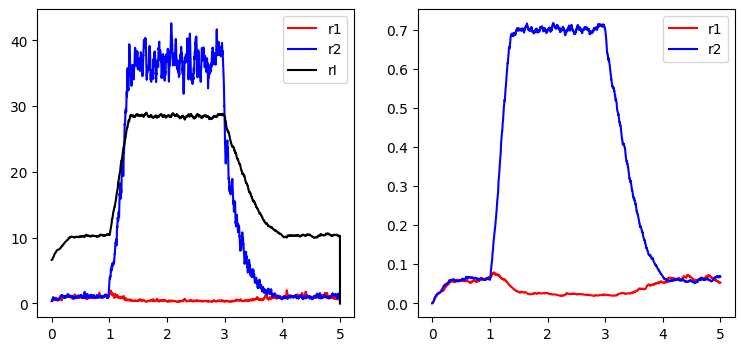

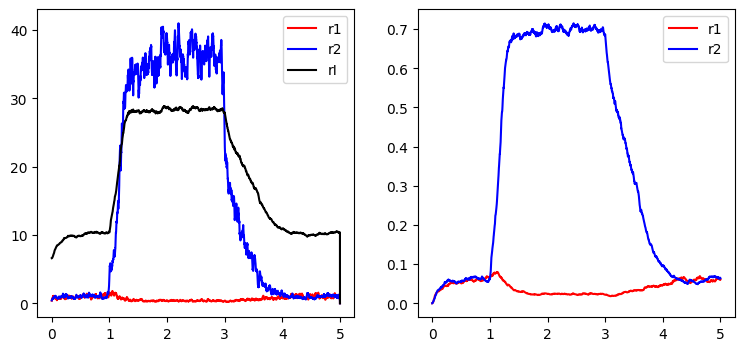

In [82]:
# PV inhibition removes persistent activity

dataset1 = run_sim(default_params(IPV_ctrl=0.01, T = 10))
dataset2 = run_sim(default_params(IPV_ctrl=0.8, T = 10))

plot_pv_data(dataset1)
plot_pv_data(dataset2)


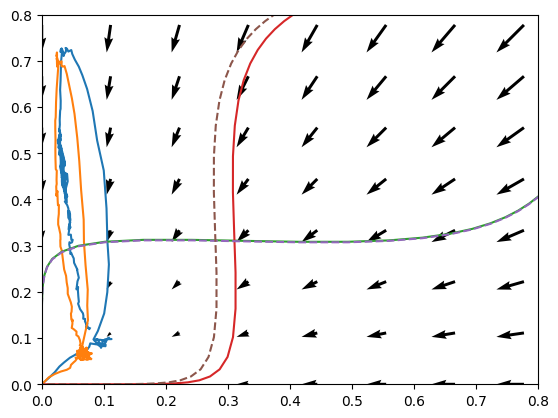

In [12]:
# plot trajectory in phase space
# reshape to smooth the data

# Nullcline for set 2
def Nullcline1_PV(I, pars, ifstim=False):
    # Given Ii, return Si and Sj
    globals().update(pars)
    a = JS + tauG * betaPV * JEI * JIE
    b = JC + tauG * betaPV * JEI * JIE
    Istim = ifstim*(Jext*mu1)
    Si = gamma * F(I) / ((1/tauS) + gamma * F(I))
    Sj = (I - a * Si - JIE * tauG * betaPV * IPV_ctrl*0.02 - JIE * tauG * betaPV * IPV_bg - Istim)/(1-b)
    return Si, Sj

def Nullcline2_PV(I, pars, ifstim=False):
    # Given Ii, return Si and Sj
    globals().update(pars)
    a = JS + tauG * betaPV * JEI * JIE
    b = JC + tauG * betaPV * JEI * JIE
    Istim = ifstim*(Jext*mu2)
    Si = gamma * F(I) / ((1/tauS) + gamma * F(I))
    Sj = (I - a * Si - JIE * tauG * betaPV * IPV_ctrl*0.02 - JIE * tauG * betaPV * IPV_bg - Istim)/(1-b)
    return Si, Sj

def deltas_PV(s1, s2, pars, ifstim=False):
    globals().update(pars)
    Istim1 = ifstim * (Jext*mu1) # To population 1
    Istim2 = ifstim * (Jext*mu2)
    IPV = JEI*s1 + JEI*s2 + IPV_ctrl*0.02 +IPV_bg
    I1 = JS*s1 + JC*s2 + JIE*tauG*betaPV*IPV#+ Istim1
    I2 = JC*s1 + JS*s2 + JIE*tauG*betaPV*IPV# + Istim2
    r1 = F(I1)
    r2 = F(I2)
    ds1dt = -s1/tauS + (1-s1)*gamma*r1
    ds2dt = -s2/tauS + (1-s2)*gamma*r2
    return ds1dt, ds2dt
    
window_size = 50
s1_1=np.mean(dataset1['S1'][1].reshape(-1,window_size), axis=1)
s2_1=np.mean(dataset1['S2'][1].reshape(-1,window_size), axis=1)

s1_2=np.mean(dataset2['S1'][1].reshape(-1,window_size), axis=1)
s2_2=np.mean(dataset2['S2'][1].reshape(-1,window_size), axis=1)
plt.xlim(0,0.8)
plt.ylim(0,0.8)
plt.plot(s1_1, s2_1)
plt.plot(s1_2, s2_2)

I1 = np.linspace(0,1)
s1_1, s2_1 = Nullcline1_PV(I1, default_params(IPV_ctrl=0), ifstim=False)
s1_2, s2_2 = Nullcline2_PV(I1, default_params(IPV_ctrl=0), ifstim=False)
plt.plot(s1_1, s2_1)
plt.plot(s2_2, s1_2)
s1_1_stim, s2_1_stim = Nullcline1_PV(I1, default_params(IPV_ctrl=1), ifstim=True)
s1_2_stim, s2_2_stim = Nullcline2_PV(I1, default_params(IPV_ctrl=1), ifstim=True)
plt.plot(s1_1_stim, s2_1_stim, ls = '--')
plt.plot(s2_2_stim, s1_2_stim, ls = '--')

s1 = np.linspace(0,1,10)
s2 = np.linspace(0,1,10)
s = np.meshgrid(s1, s2)
ds1dt, ds2dt = deltas_PV(s[0], s[1], default_params(), ifstim=False)
plt.quiver(s1, s2, ds1dt, ds2dt)